<ipython-input-12-1dd86e3547e1>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = pd.read_csv(SIGNALS_CSV).astype("float32")[parameters["beta1_IC_b"] > 0]


(1764, 256)


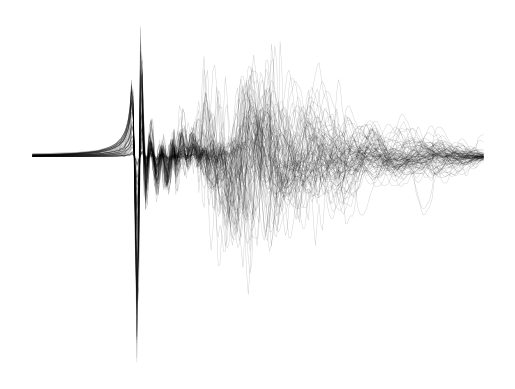

In [12]:
import pandas as pd

_ROOT_URL = "https://raw.githubusercontent.com/starccato/data/main/training"
SIGNALS_CSV = f"{_ROOT_URL}/richers_1764.csv"
PARAMETERS_CSV = f"{_ROOT_URL}/richers_1764_parameters.csv"

parameters = pd.read_csv(PARAMETERS_CSV)
data = pd.read_csv(SIGNALS_CSV).astype("float32")[parameters["beta1_IC_b"] > 0]
data = data.values.T[:, 140:] # cut the first few datapoints
row_means = np.mean(data, axis=1, keepdims=True)
row_stds  = np.std(data, axis=1, keepdims=True)
data = (data - row_means) / row_stds


for i in range(100):
  plt.plot(data[i], color='k', lw=0.3, alpha=0.2)

print(data.shape)
np.save('data.npy', data)


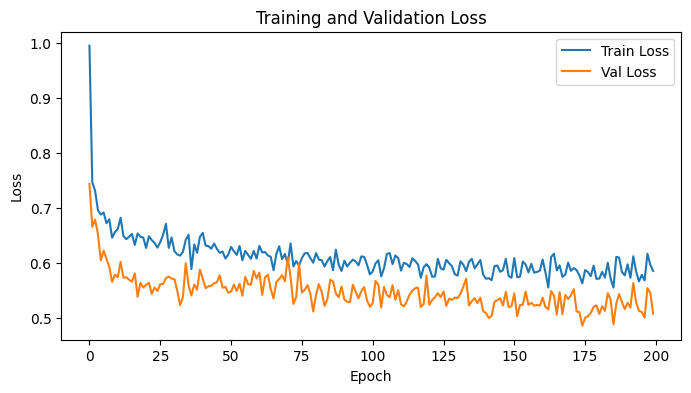

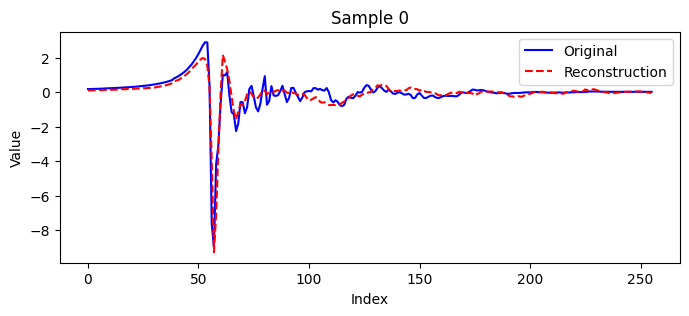

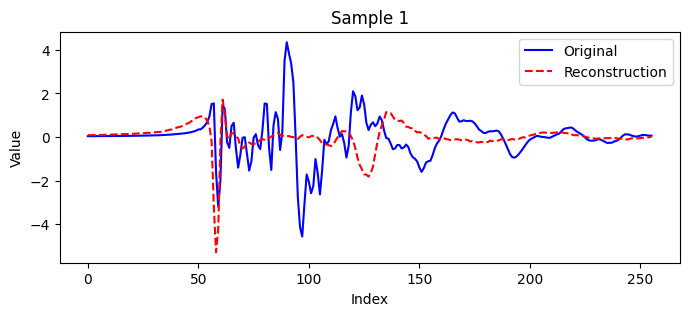

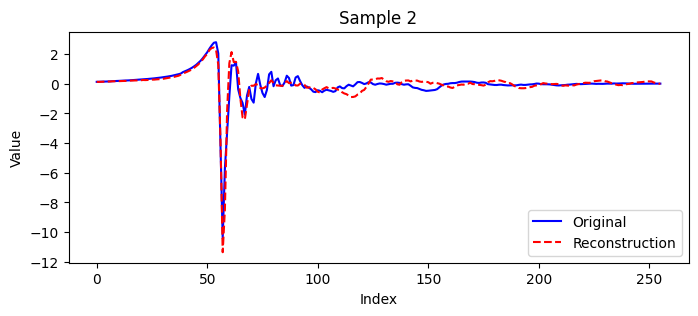

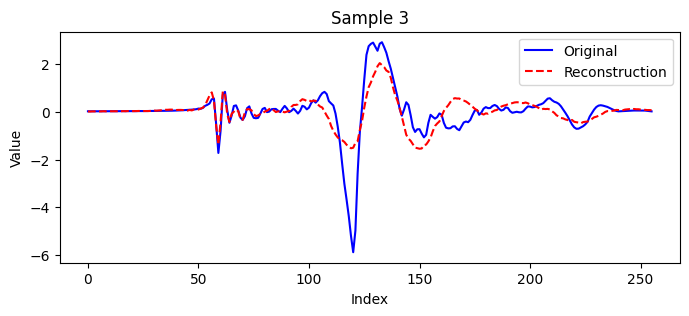

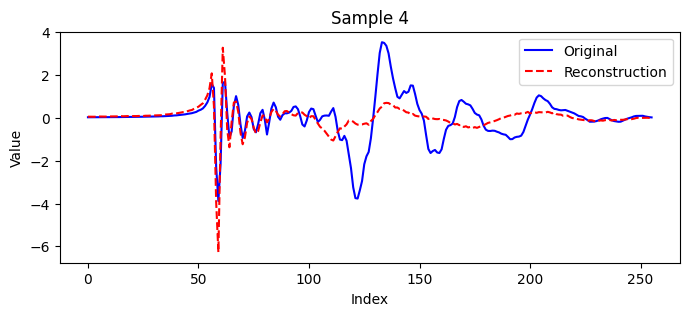

Model saved to /tmp/my-checkpoints/vae_checkpoint


/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


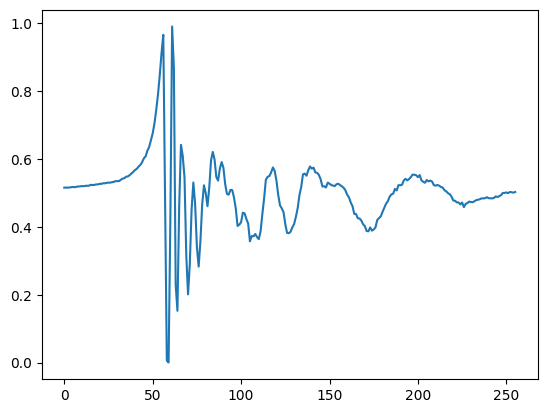

In [113]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
from flax import linen as nn
from flax.training import train_state
from functools import partial
import flax.serialization
import orbax.checkpoint as ocp
from flax.training import orbax_utils
import orbax
from flax.training import checkpoints



# ------------------------------
# Data Loading and Preprocessing
# ------------------------------
# Assume your data is stored in a numpy file.
data = np.load("data.npy")  # shape (1764, 256)
N_SAMPLES, DATA_LEN = data.shape

class Encoder(nn.Module):
  """VAE Encoder."""

  latents: int

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(512, name='fc1')(x)
    x = nn.relu(x)
    mean_x = nn.Dense(self.latents, name='fc2_mean')(x)
    logvar_x = nn.Dense(self.latents, name='fc2_logvar')(x)
    return mean_x, logvar_x


class Decoder(nn.Module):
  """VAE Decoder."""

  @nn.compact
  def __call__(self, z):
    z = nn.Dense(512, name='fc1')(z)
    z = nn.relu(z)
    z = nn.Dense(256, name='fc2')(z)
    return z


class VAECore(nn.Module):
  """Full VAE model."""

  latents: int = 20

  def setup(self):
    self.encoder = Encoder(self.latents)
    self.decoder = Decoder()

  def __call__(self, x, z_rng):
    mean, logvar = self.encoder(x)
    z = reparameterize(z_rng, mean, logvar)
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nn.sigmoid(self.decoder(z))


def reparameterize(rng, mean, logvar):
  std = jnp.exp(0.5 * logvar)
  eps = random.normal(rng, logvar.shape)
  return mean + eps * std


def VAE(latent_dim):
  return VAECore(latent_dim)

# ------------------------------
# Loss function and training step.
# ------------------------------
def vae_loss(params, x, rng, model):
    reconstructed, mean, logvar = model.apply({'params': params}, x, rng)
    reconstruction_loss = jnp.mean((x - reconstructed) ** 2)
    kl_divergence = -0.5 * jnp.mean(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    return reconstruction_loss + kl_divergence

@partial(jax.jit, static_argnames=("model",))
def train_step(state, x, rng, model):
    loss, grads = jax.value_and_grad(lambda params: vae_loss(params, x, rng, model))(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# ------------------------------
# Create training state with configurable latent_dim.
# ------------------------------
def create_train_state(rng, latent_dim, learning_rate=1e-3):
    model = VAE(latent_dim=latent_dim)
    # Initialize the model with dummy data of shape (1, DATA_LEN)
    params = model.init(rng, jnp.ones((1, DATA_LEN)), rng)['params']
    tx = optax.adam(learning_rate)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model

# ------------------------------
# Training loop.
# ------------------------------
def train_vae(train_data, val_data, latent_dim, n_epochs=1000, batch_size=32):
    rng = jax.random.PRNGKey(0)
    state, model = create_train_state(rng, latent_dim)
    train_losses = []
    val_losses = []
    n_train = train_data.shape[0]
    n_val = val_data.shape[0]

    for epoch in range(n_epochs):
        # Shuffle training data indices.
        perm = np.random.permutation(n_train)
        epoch_train_loss = 0.
        n_batches = 0
        rng, subkey = jax.random.split(rng)
        for i in range(0, n_train, batch_size):
            batch_idx = perm[i:i + batch_size]
            # Since the train_data is already a JAX device array, slicing is efficient.
            batch = train_data[batch_idx]
            state, loss = train_step(state, batch, subkey, model)
            epoch_train_loss += loss
            n_batches += 1
        epoch_train_loss /= n_batches
        train_losses.append(epoch_train_loss)

        # Validation loss
        epoch_val_loss = 0.
        n_batches_val = 0
        for i in range(0, n_val, batch_size):
            batch = val_data[i:i + batch_size]
            loss = vae_loss(state.params, batch, subkey, model)
            epoch_val_loss += loss
            n_batches_val += 1
        epoch_val_loss /= n_batches_val
        val_losses.append(epoch_val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

    return state, model, train_losses, val_losses

# ------------------------------
# Plotting functions.
# ------------------------------
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_reconstructions(state, model, val_data, num_samples=5):
    rng = jax.random.PRNGKey(0)
    idx = np.random.choice(val_data.shape[0], num_samples, replace=False)
    samples = val_data[idx]
    reconstructed, _, _ = model.apply({'params': state.params}, samples, rng)
    reconstructed = np.array(reconstructed)
    for i in range(num_samples):
        plt.figure(figsize=(8, 3))
        plt.plot(np.array(samples[i]), 'b-', label='Original')
        plt.plot(reconstructed[i], 'r--', label='Reconstruction')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title(f'Sample {i}')
        plt.legend()
        plt.show()



# --------------------------------------------
# Save and Load Functions with Orbax
# --------------------------------------------

def save_model(state, config, filename="/tmp/flax_ckpt/MODEL"):
    """ Saves model parameters and config using Orbax CheckpointManager """
    checkpt = {'state': state, 'config': config,}
    checkpoints.save_checkpoint(
        ckpt_dir=filename,
        target=checkpt,
        step=0,
        overwrite=True,
        keep=2
        )
    print(f"Model saved to {filename}")


def load_model(filename="/tmp/flax_ckpt/MODEL"):
    """ Loads model parameters and config using Orbax CheckpointManager """
    raw_restored = checkpoints.restore_checkpoint(ckpt_dir=filename, target=None)
    return raw_restored["state"], raw_restored["config"]


# ------------------------------
# Generation function using the separate Decoder.
# ------------------------------
def generate_signal(state_params, latent_dim, rng_seed=42):
    rng = jax.random.PRNGKey(rng_seed)
    # Generate a random latent vector (batch size 1).
    z = jax.random.normal(rng, shape=(1, latent_dim))
    p = {'params':state_params['params']}
    return VAE(latent_dim).apply(p, z, method=VAECore.generate)


# ------------------------------
# Main
# ------------------------------
# if __name__ == "__main__":


# Set the desired latent dimension.
latent_dim = 12

# Split data into training (80%) and validation (20%) sets.
n_total = data.shape[0]
n_train = int(0.8 * n_total)
train_data_np = data[:n_train]
val_data_np = data[n_train:]

# Optionally, standardize each sample (row) to have zero mean and unit variance.
train_means = np.mean(train_data_np, axis=1, keepdims=True)
train_stds  = np.std(train_data_np, axis=1, keepdims=True)
train_data_np = (train_data_np - train_means) / train_stds

val_means = np.mean(val_data_np, axis=1, keepdims=True)
val_stds  = np.std(val_data_np, axis=1, keepdims=True)
val_data_np = (val_data_np - val_means) / val_stds

# Convert preprocessed data to JAX device arrays once.
train_data = jax.device_put(train_data_np)
val_data = jax.device_put(val_data_np)

# Train the VAE.
# state, model, train_losses, val_losses = train_vae(train_data, val_data, latent_dim, n_epochs=200, batch_size=32)
plot_loss(train_losses, val_losses)
plot_reconstructions(state, model, val_data)

# Prepare a configuration dictionary.
config = {"latent_dim": latent_dim}

# Save model
save_model(state, {"latent_dim": latent_dim}, filename=f"{ckpt_dir}/vae_checkpoint")

# Load model
loaded_state, loaded_config = load_model(f"{ckpt_dir}/vae_checkpoint")
latent_dim_loaded = loaded_config["latent_dim"]


# # Generate a random latent vector (batch size 1).
z = jax.random.normal(rng, shape=(1, latent_dim))
# # Use the standalone decoder. The decoder's parameters are stored under "decoder".
plt.plot(generate_signal(loaded_state, latent_dim, 0)[0])
